In [1]:
import os
from os.path import join
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.io import savemat
from bct.algorithms.clustering import agreement, consensus_und
from dn_utils.networks import networks_mean
from dn_utils.plotting import plot_matrix, aligned_imshow_cbar

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_root = os.environ.get("DECIDENET_PATH")

path_derivatives = join(path_root, "data/main_fmri_study/derivatives")
path_sourcedata = join(path_root, "data/main_fmri_study/sourcedata") 

path_beh = join(path_sourcedata, "behavioral")
path_bsc = join(path_derivatives, "bsc")
path_nistats = join(path_derivatives, "nistats")
path_parcellations = join(path_derivatives, "parcellations")

path_corrmats = join(path_bsc, "corrmats")

### Settings

In [3]:
atlas = "combined_roi"
alpha_fdr = 1e-10

### Load data

In [4]:
alpha_fdr_str = str(alpha_fdr).replace("-", "")
path_fdrthr = join(path_corrmats, f"{atlas}/fdrthr_{alpha_fdr_str}")

# Load correlation matrices and metadata
corrmats_aggregated = np.load(join(path_corrmats, atlas, 
                                   "corrmats_aggregated.npy"))
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    corrmats_meta = json.loads(f.read()) 
    
n_subjects = len(corrmats_meta["dim1"])
n_conditions = len(corrmats_meta["dim2"])
n_perr_sign = len(corrmats_meta["dim3"])
n_roi = len(corrmats_meta["dim4"])
    
# Load subject exclusion
df_exclusion = pd.read_csv(join(path_nistats, "exclusion/exclusion.csv"), 
                           index_col=0)
ok_index = df_exclusion["ok_all"]
n_subjects_ok = sum(ok_index)

# Load statistical threshold
pvalues_mask = np.load(join(path_fdrthr, "pvalues_mask.npy"))

# Load ROI information
df_roi = pd.read_csv(join(path_corrmats, atlas, "roi_table_filtered.csv"), 
                    index_col=0)
df_roi = df_roi.reset_index()

# Apply thresholding
corrmats_aggregated_thr = corrmats_aggregated * (corrmats_aggregated > 0)
corrmats_aggregated_thr = corrmats_aggregated_thr * pvalues_mask

In [5]:
path_nbs = join(path_fdrthr, "nbs")
Path(path_nbs).mkdir(exist_ok=True)

corrmats_nbs_perr_sign = np.zeros((n_roi, n_roi, n_subjects_ok * 2))

k = 0
for perr_sign_idx in range(n_perr_sign):
    for sub_idx in range(n_subjects_ok):
        print(f"perr_sign_idx: {perr_sign_idx}", f"sub: {sub_idx}")
        corrmats_nbs_perr_sign[:, :, k] = np.mean(
            corrmats_aggregated_thr[sub_idx, :, perr_sign_idx], 
            axis=0)
        k += 1
            
savemat(
    file_name=join(path_nbs, "corrmats_perr_sign_stacked.mat"),
    mdict={"corrmats_perr_sign_stacked": corrmats_nbs_perr_sign}
)

perr_sign_idx: 0 sub: 0
perr_sign_idx: 0 sub: 1
perr_sign_idx: 0 sub: 2
perr_sign_idx: 0 sub: 3
perr_sign_idx: 0 sub: 4
perr_sign_idx: 0 sub: 5
perr_sign_idx: 0 sub: 6
perr_sign_idx: 0 sub: 7
perr_sign_idx: 0 sub: 8
perr_sign_idx: 0 sub: 9
perr_sign_idx: 0 sub: 10
perr_sign_idx: 0 sub: 11
perr_sign_idx: 0 sub: 12
perr_sign_idx: 0 sub: 13
perr_sign_idx: 0 sub: 14
perr_sign_idx: 0 sub: 15
perr_sign_idx: 0 sub: 16
perr_sign_idx: 0 sub: 17
perr_sign_idx: 0 sub: 18
perr_sign_idx: 0 sub: 19
perr_sign_idx: 0 sub: 20
perr_sign_idx: 0 sub: 21
perr_sign_idx: 0 sub: 22
perr_sign_idx: 0 sub: 23
perr_sign_idx: 0 sub: 24
perr_sign_idx: 0 sub: 25
perr_sign_idx: 0 sub: 26
perr_sign_idx: 0 sub: 27
perr_sign_idx: 0 sub: 28
perr_sign_idx: 1 sub: 0
perr_sign_idx: 1 sub: 1
perr_sign_idx: 1 sub: 2
perr_sign_idx: 1 sub: 3
perr_sign_idx: 1 sub: 4
perr_sign_idx: 1 sub: 5
perr_sign_idx: 1 sub: 6
perr_sign_idx: 1 sub: 7
perr_sign_idx: 1 sub: 8
perr_sign_idx: 1 sub: 9
perr_sign_idx: 1 sub: 10
perr_sign_idx: 1 sub

In [6]:
# Create design matrix
reg_con_1 = np.repeat([1, 0], n_subjects_ok)[:, np.newaxis]
reg_con_2 = 1 - reg_con_1
regs_sub = np.tile(np.eye(n_subjects_ok), 2).T
reg_intercept = np.ones((n_subjects_ok * 2, 1))

dm = np.hstack((
    reg_con_1, 
    reg_con_2, 
    regs_sub, 
    reg_intercept,
))

savemat(
    file_name=join(path_nbs, "design_matrix.mat"),
    mdict={"dm": dm}
)

savemat(
    file_name=join(path_nbs, "coordinates.mat"),
    mdict={"rois": df_roi[["x", "y", "z"]].values}
)

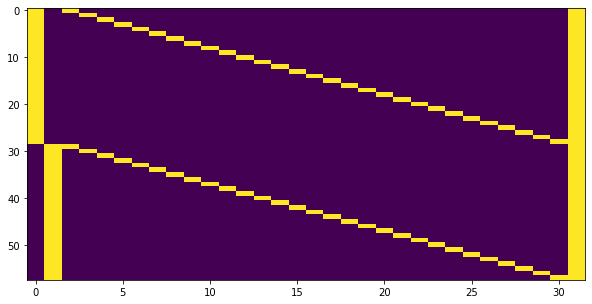

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(dm, aspect="auto", interpolation="none")